In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns     # you can install this with "pip install seaborn"
import sys
import pprint, math
from process_logs import *  # various functions used to process experiment log file
%matplotlib inline  
#print(plt.rcParams.keys())
params = {'font.size': 18, 'figure.titlesize':'medium','legend.fontsize': 'medium','legend.handlelength':1,
          'lines.linewidth':2, 'lines.markersize':12, 'legend.handletextpad':0,'axes.formatter.useoffset':False,}
plt.rcParams.update(params)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
sns.set_style("whitegrid")   
print('Baseline power',baseline_power)

Baseline power 25.24939


## Settings
Edit the variables below to indicate which plots to generate, the algs list is a list of subdirectories with results (they must contain the file parsed-power-aggregate.txt.

In [43]:
algs = ['MST/output-16epv','MST/output-8epv','MST/output-real','CC/output-16epv','CC/output-8epv','CC/output-real']
algs = ['MST/output-8epv-new','MST/output-real-new']
#algs = ['CC/output-8epv','CC/output-real']
whats = {'Energy':'Total CPU Energy (J)','Power':'Average CPU Power (W)', 'Memory':'Total Memory (GB)','Time':'Time (seconds)'}
#whats = {'Memory':'Total Memory (GB)'}
speedup = False
epvs = ['8']
nws = ['ER','G']
#nws = ['com-lj-org-weighted','soc-pokec','youtubeNetwork']
insperc = ['100','75']

## Functions
A couple of functions that extract the data and generate the plots.

In [44]:
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']))
        
def genBoxPlot(alg, what, ddf, network, speedup = False):
    # df should be for a single network
    global whats
    print(alg,what,network)
    if ddf.empty: 
        print(': No data'); 
        return
     
    df=ddf[ddf['what'].str.contains(what)].copy()
    #print(df.head(12))
    df['what'].replace(what,whats[what])
    df.sort_values(by=['Threads'],inplace=True)
    
    # Check if there is any deletion (<100% insertion)
    parts = network.split('_')
    if network.find('_100i_')>0: nodeletion = True
    else: nodeletion = False
    value_vars_speedup = []

    # Figure settings
    fig, ax = plt.subplots()
    if speedup: fig.set_size_inches(12,8)
    elif what == 'Memory': fig.set_size_inches(8,4)
    else: fig.set_size_inches(8,8)

    legend_columns = 1; legend_placement = 'upper right'
    if what == 'Power': legend_placement = 'upper left'
    all_colors = {alg+'-ins-p0' : '#5566fc', alg+'-ins-p1' : '#7f8cff', 
                alg+'-del-p0' : '#019cad', alg+'-del-p1' : '#00cee5', alg + '-Total': '#0217d6',
                'Galois-p0' : '#ff3a3a', 'Galois-p1' : '#ffa456','Galois-Total' : '#af0000',
                alg+'-Memory' : '#0217d6', 'Galois-Memory' : '#af0000',
                alg+'-Speedup' : '#0217d6', 'Galois-Speedup' : '#af0000', 'Ideal' : '#00AA00',
                'Baseline' : "#f6ff0a"}
    if what != "Memory":
        if what == "Time":
            value_vars = [alg+'-ins-p0']
            if not nodeletion: 
                value_vars += [alg + '-del-p0',alg + '-Total']
                new_labels=[alg+'-ins',alg+'-del',alg+'-Total','Galois']
            else: new_labels = [alg,'Galois']
            value_vars += ['Galois-p0']
            legend_placement = 'upper right'
            value_vars_speedup = [alg+'-Speedup','Galois-Speedup','Ideal']
        else: 
            value_vars = [alg+'-ins-p0',alg+'-ins-p1']
            if not nodeletion: 
                value_vars += [alg + '-del-p0', alg+'-del-p1']
            value_vars += ['Galois-p0','Galois-p1',alg + '-Total','Galois-Total']
            new_labels = value_vars
    else:
        value_vars = [alg+'-Memory','Galois-Memory']
        new_labels = value_vars
        legend_placement = 'center left'

    if what == "Power": value_vars.append("Baseline")
        
    if what == "Time" and speedup: 
        legend_placement = 'upper left'
        value_vars = value_vars_speedup
        
    # Done setting value_vars, now create colormap
    #print(all_colors,value_vars)
    colors = [all_colors[x] for x in value_vars]

    dd=pd.melt(df, id_vars=['Threads'], value_vars=value_vars, var_name='Operation')
   
    #ax = sns.barplot(ax=ax,x='Threads',y='value',data=dd,hue='Operation',palette="Set3")
   
    sns.set_palette(sns.color_palette(colors))
    if what in ["Time","Memory"]:
        markers=["^","*","x",'o','']
        linestyles=["-", "--", ":",'-.','--']
        if len(value_vars) == 2:  markers=["^",'o']; linestyles=["-", ":"]
        g = sns.pointplot(x='Threads',y='value',data=dd,hue='Operation', ax=ax, legend=False,
                          markers=markers, linestyles=linestyles) 
    else:
        #sns.boxplot(x='Threads',y='value',data=dd,hue='Operation', ax=ax) 
        g = sns.pointplot(x='Threads',y='value',data=dd,hue='Operation', ci=None, ax=ax, legend=False, 
                          markers=['^', '1','*','o','x','+','2','p','.'], 
                          linestyles=["-", "--", ":",'-.','-',':','--','-.','-'])
    if not speedup: sns.despine(offset=10, trim=True)
    
    
    # Legend
    handles, labels = ax.get_legend_handles_labels()
    if len(value_vars) >6: legend_columns = 2
    plt.legend(handles, labels, loc=legend_placement, frameon=True, framealpha=0.8, 
               ncol=legend_columns, columnspacing=1)

    #plt.subplots_adjust(top=.925)
    
    #Title
    title = network + ": " +whats[what]
    filename = alg.upper() + "_" + network + "_" + what + '.pdf'
    plt.xlabel("Number of Threads")
    # Axes
    ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
    ymin,ymax = ax.get_ylim(); new_ymax = ymax
    if not speedup:
        if not network.startswith('24') and what == 'Power': new_ymax = 1.2*ymax
        if what != 'Memory': 
            new_ymax=1.1 * ymax
            ax.set(xlim=(0, None),ylim=(ymin,new_ymax))
        else: 
            #if network in ['248_ER_75i_1000000','248_ER_75i_1000000']: ax.set(ylim=(0,3))
            #else: ax.set(xlim=(0, None),ylim=(0,13))
            ax.yaxis.set_minor_locator(plt.MultipleLocator(10))
            #ax.set_yticks([0,2,4,6,8,10,12])
            #ax.set_yticklabels([0,2,4,6,8,10,12])
        plt.ylabel(whats[what])
    else:
        title = network + ": Speedup"
        ax.set_yscale('symlog')#;ax.set_xscale('symlog')
        filename = alg.upper() + "_" + network + '_Speedup.pdf'
        ax.set(xlim=(1, None),ylim=(1,None))
        ax.set_yticks([2,4,8,16,32,48,64,72])
        ax.set_yticklabels([2,4,8,16,32,48,64,72])#, fontdict={'fontsize':14})
        plt.ylabel(r"$T_1/T_n$ (log scale)"); plt.xlabel("Number of Threads (n)")
   
    plt.title(title)
    if what == 'Memory': plt.tight_layout()
    plt.savefig(filename)
    plt.show()

## Driver for generating all the plots
All the data structures are populated by extractData and plots are generated with genBoxPlot

MST Time 248_ER_75i_1000000


/Applications/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


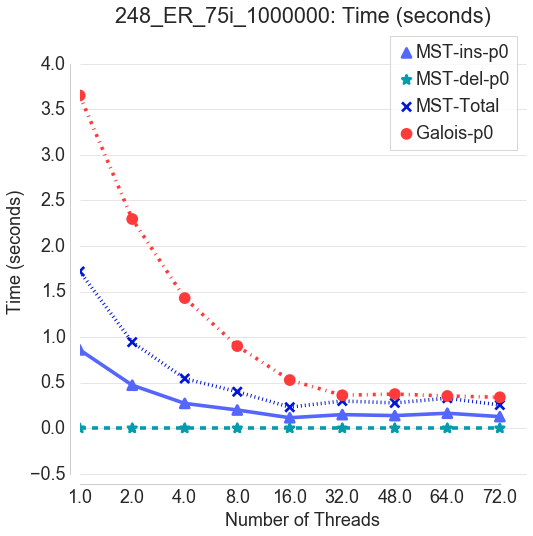

MST Time 248_G_75i_1000000


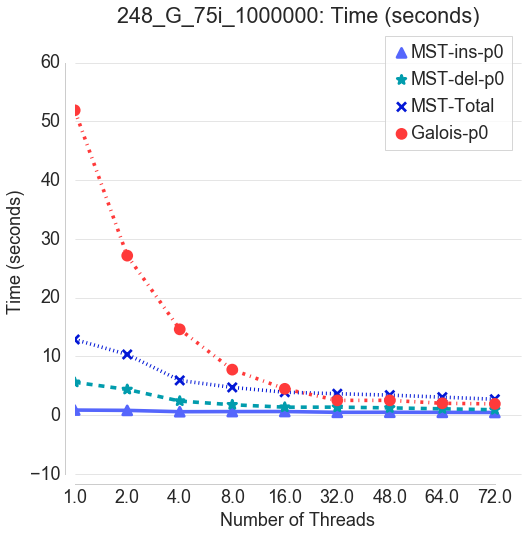

MST Time 248_ER_100i_1000000


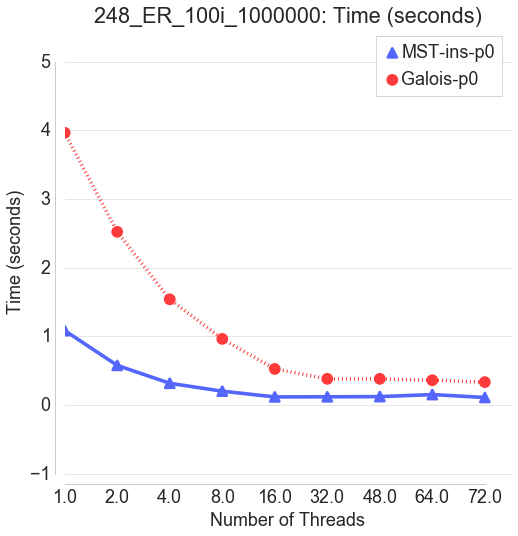

MST Time 248_G_100i_1000000


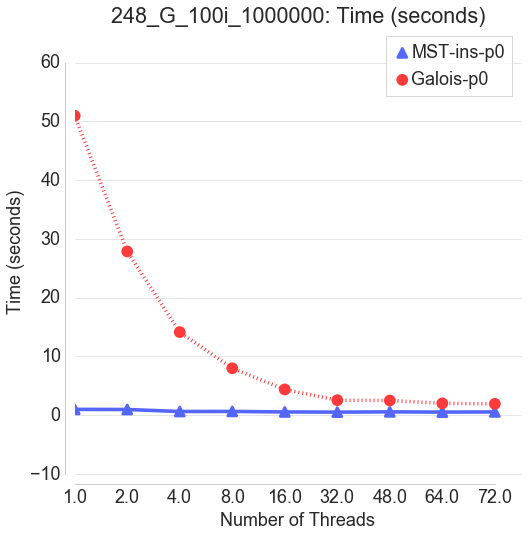

MST Power 248_ER_75i_1000000


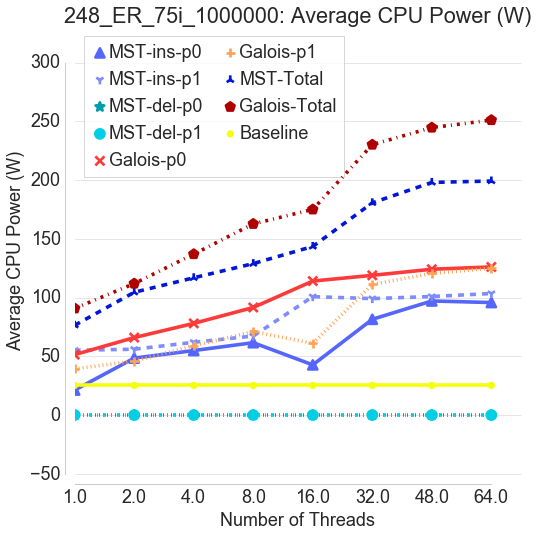

MST Power 248_G_75i_1000000


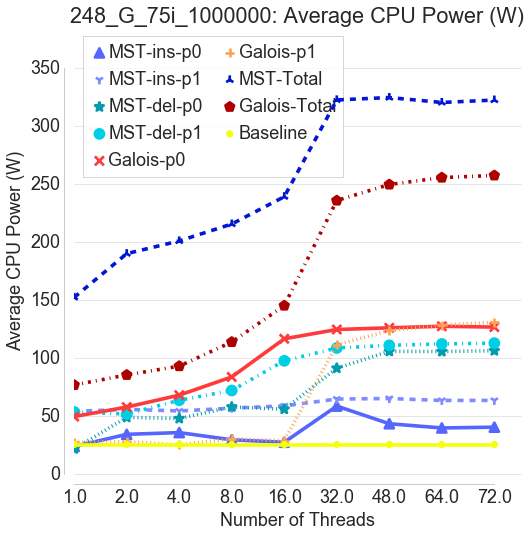

MST Power 248_ER_100i_1000000


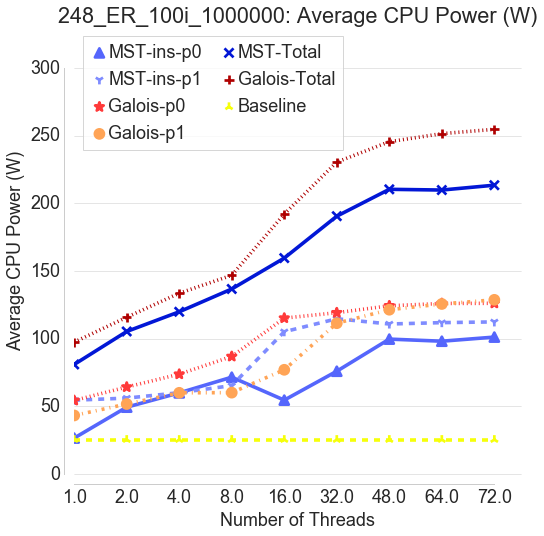

MST Power 248_G_100i_1000000


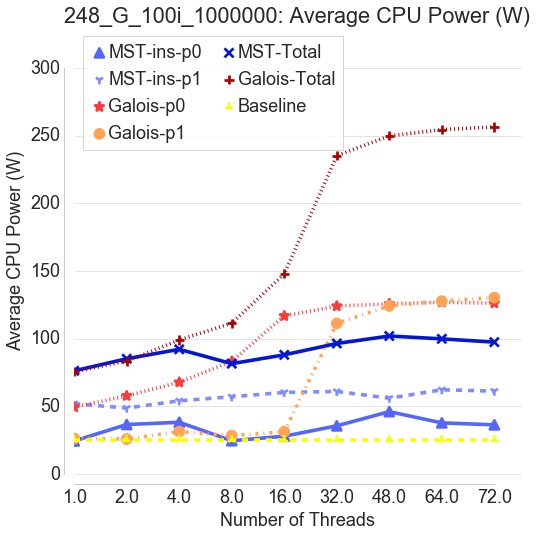

MST Energy 248_ER_75i_1000000


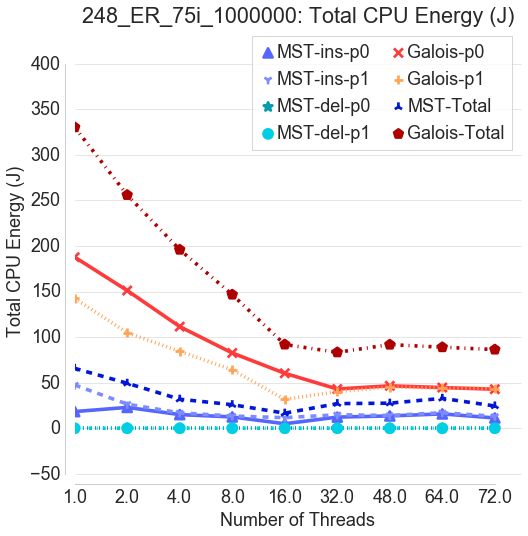

MST Energy 248_G_75i_1000000


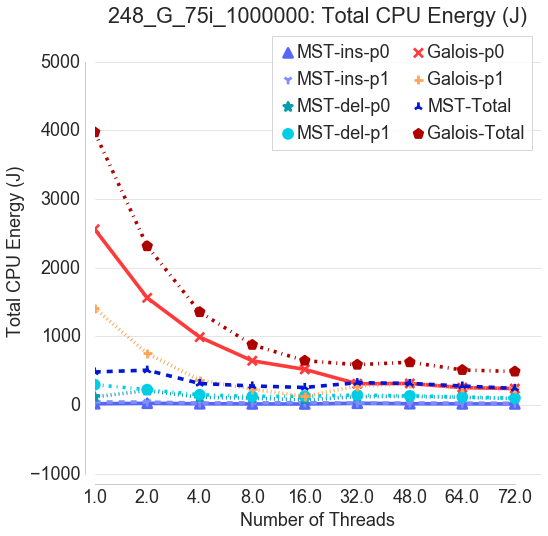

MST Energy 248_ER_100i_1000000


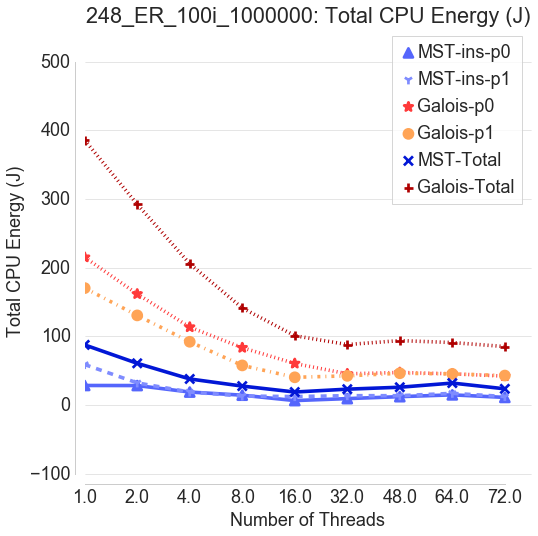

MST Energy 248_G_100i_1000000


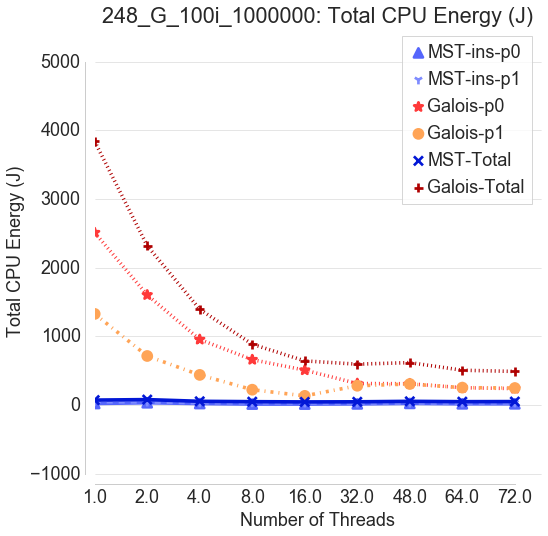

MST Memory 248_ER_75i_1000000


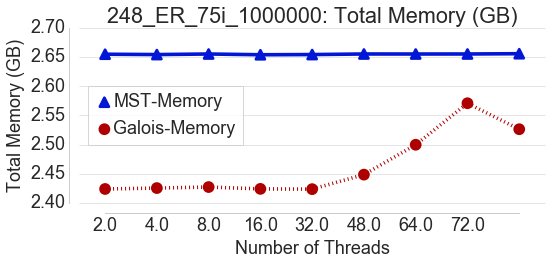

MST Memory 248_G_75i_1000000


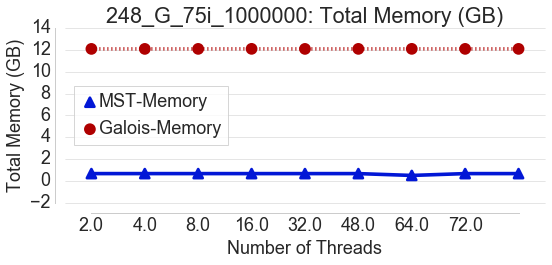

MST Memory 248_ER_100i_1000000


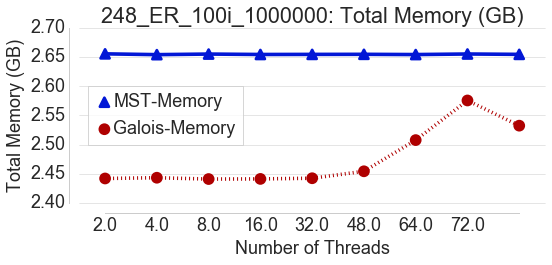

MST Memory 248_G_100i_1000000


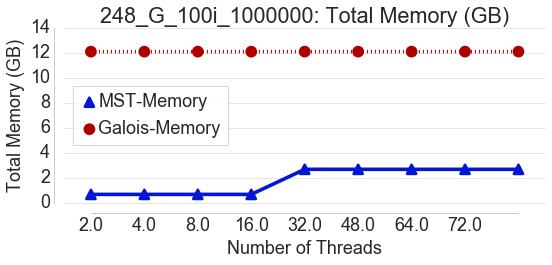

MST Time soc-pokec_75i_1000000


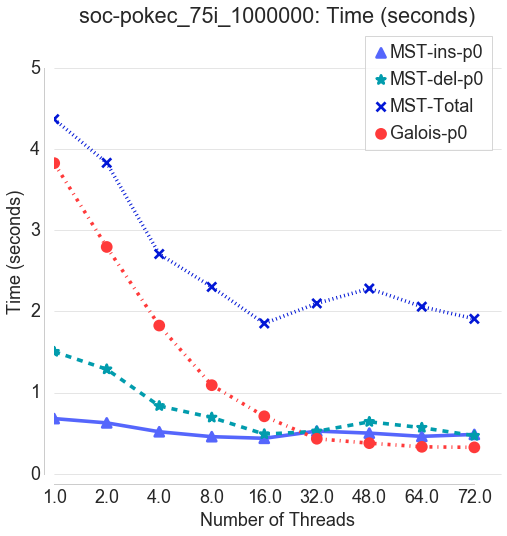

MST Time youtubeNetwork_100i_1000000


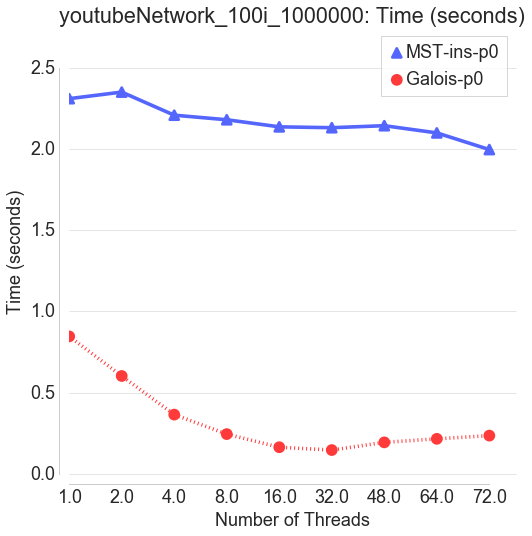

MST Time com-lj-org-weighted_75i_1000000


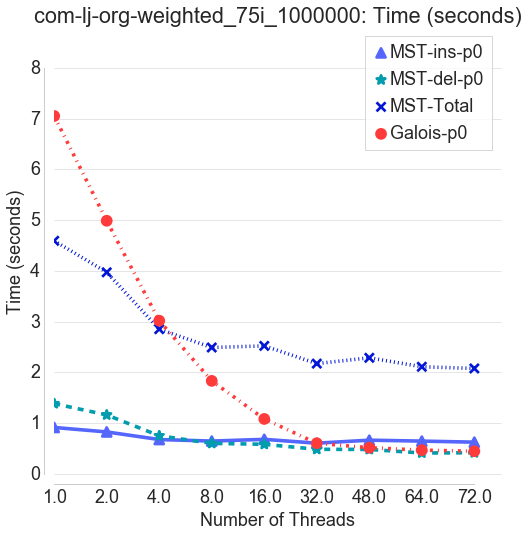

MST Time youtubeNetwork_75i_1000000


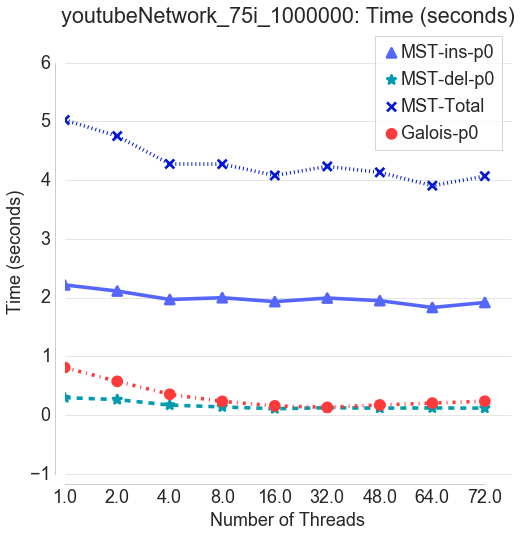

MST Time com-lj-org-weighted_100i_1000000


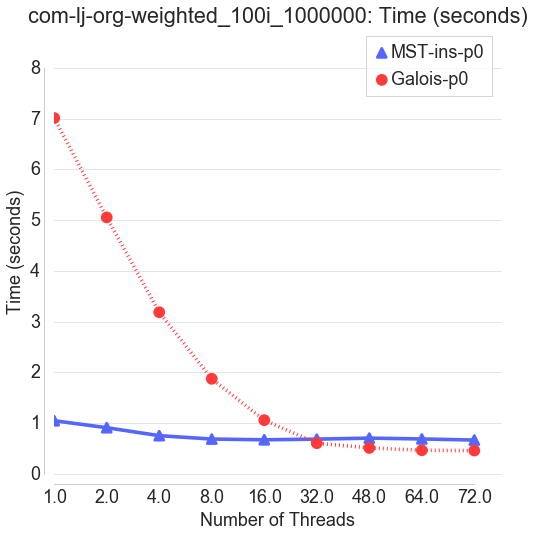

MST Time soc-pokec_100i_1000000


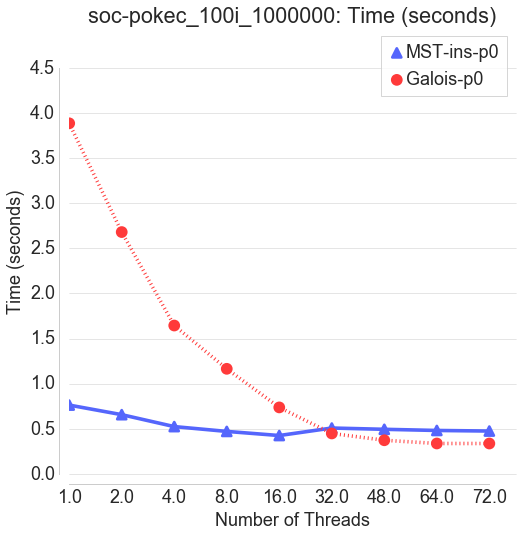

MST Power soc-pokec_75i_1000000


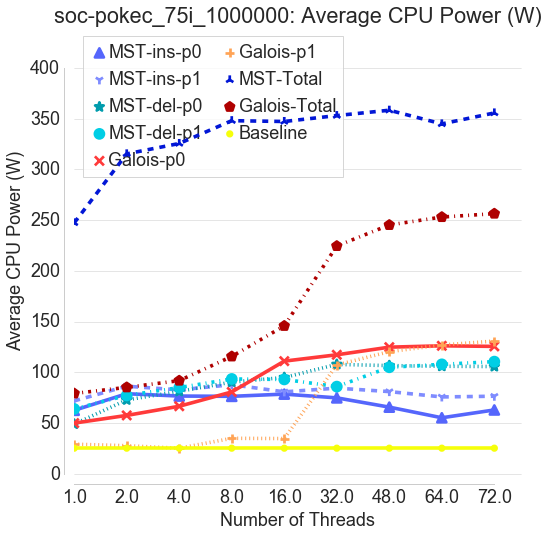

MST Power youtubeNetwork_100i_1000000


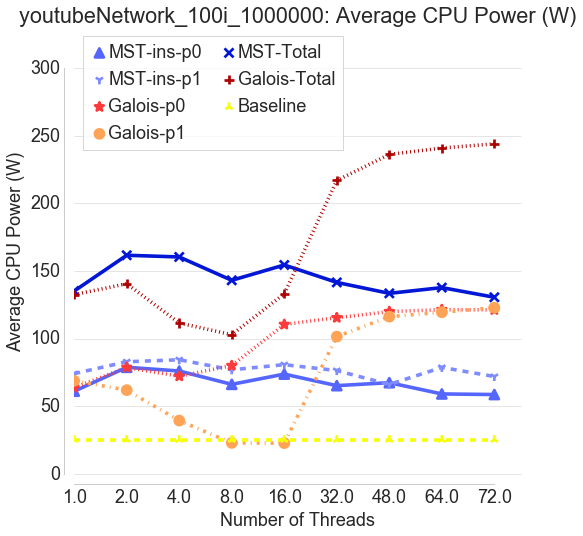

MST Power com-lj-org-weighted_75i_1000000


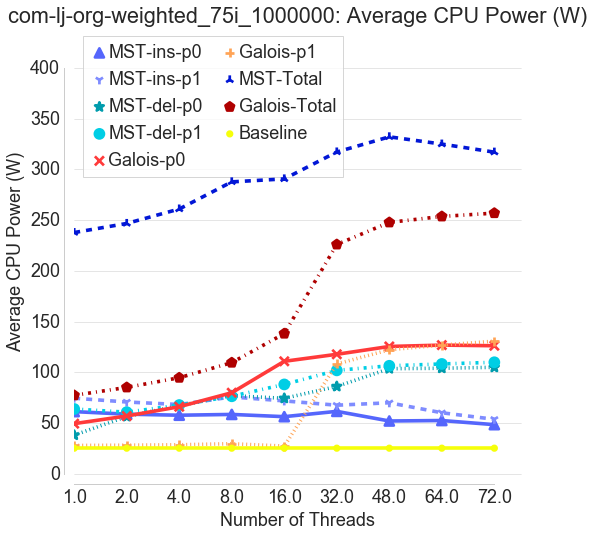

MST Power youtubeNetwork_75i_1000000


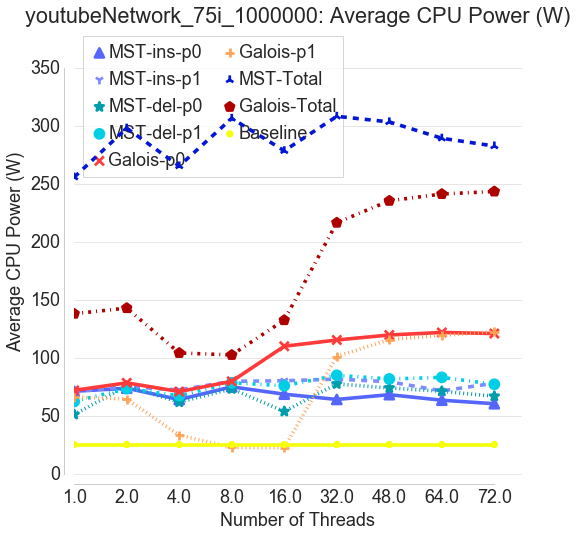

MST Power com-lj-org-weighted_100i_1000000


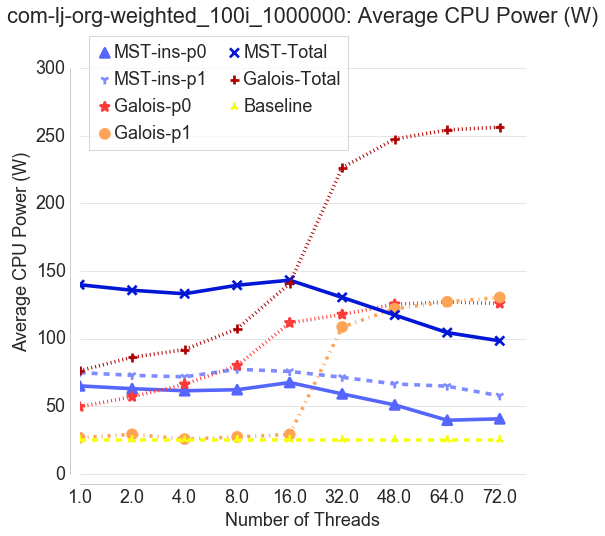

MST Power soc-pokec_100i_1000000


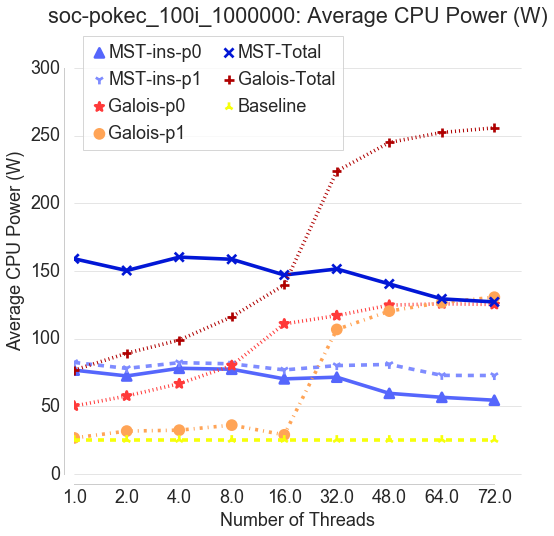

MST Energy soc-pokec_75i_1000000


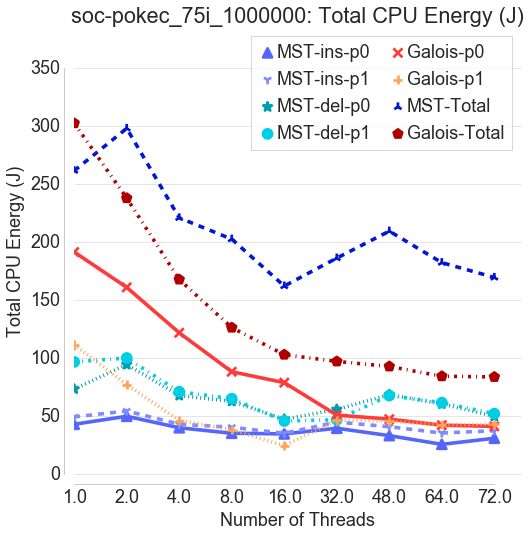

MST Energy youtubeNetwork_100i_1000000


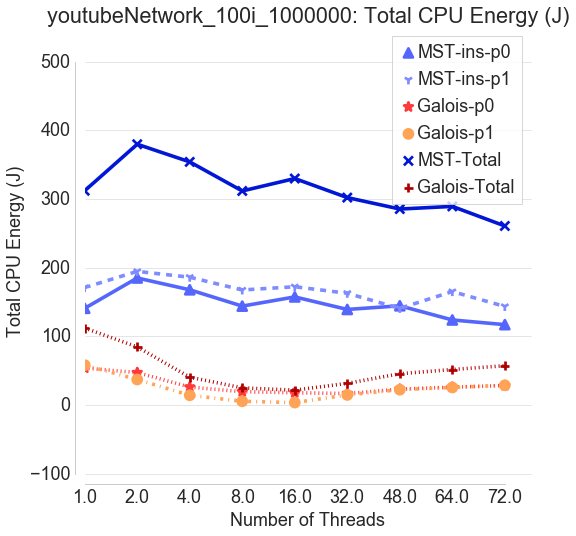

MST Energy com-lj-org-weighted_75i_1000000


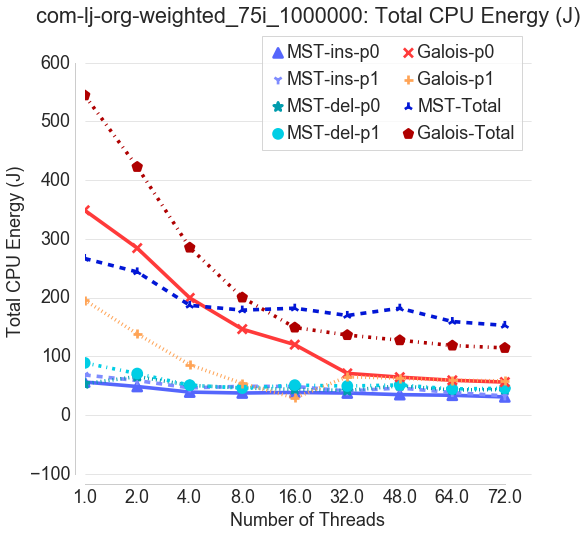

MST Energy youtubeNetwork_75i_1000000


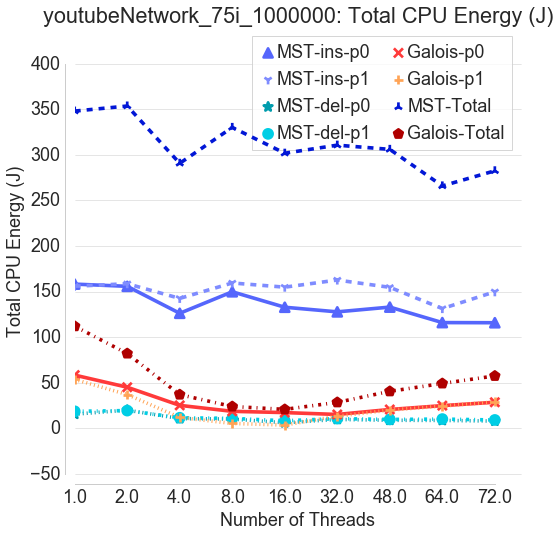

MST Energy com-lj-org-weighted_100i_1000000


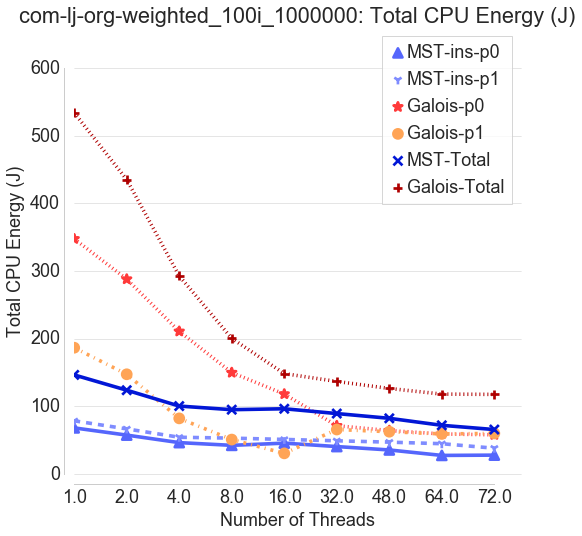

MST Energy soc-pokec_100i_1000000


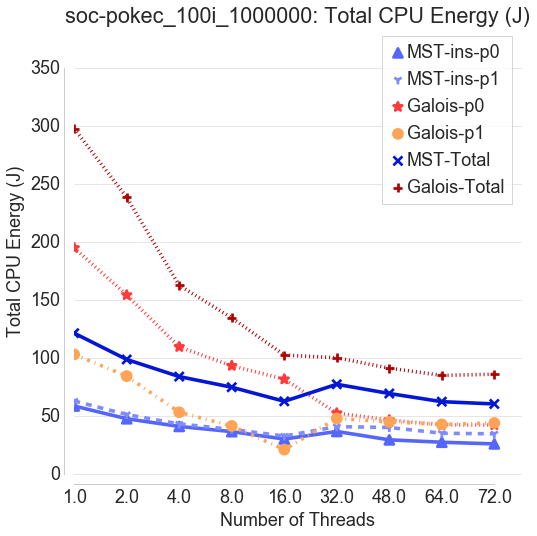

MST Memory soc-pokec_75i_1000000


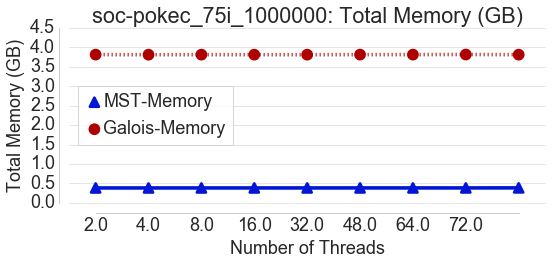

MST Memory youtubeNetwork_100i_1000000


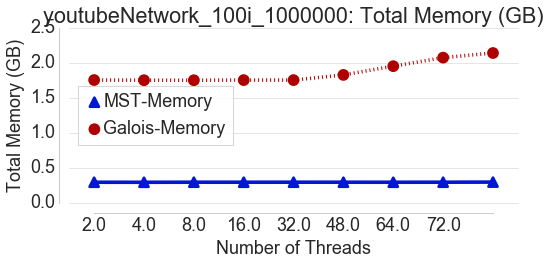

MST Memory com-lj-org-weighted_75i_1000000


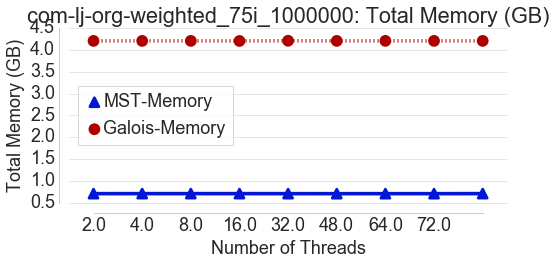

MST Memory youtubeNetwork_75i_1000000


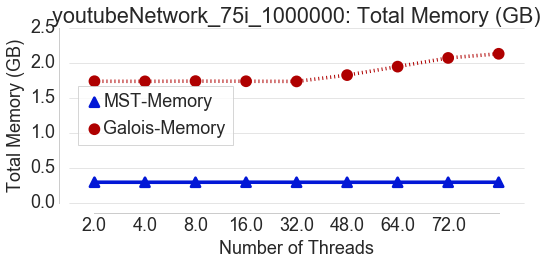

MST Memory com-lj-org-weighted_100i_1000000


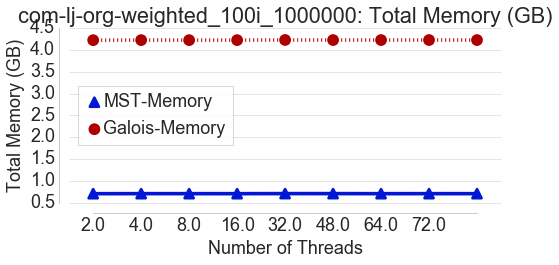

MST Memory soc-pokec_100i_1000000


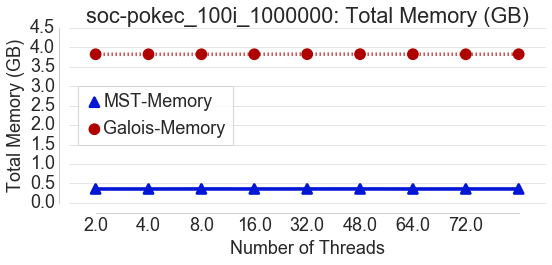

In [45]:
algnames = [x.split('/')[0] for x in algs]
pp = pprint.PrettyPrinter(indent=2)

for algfull in algs:
    alg = algfull.split('/')[0]
    networks = processLogs(algfull)
    allnets = []
    summaries = []
    columns = ["what","Network", "Threads", alg+"-ins-p0", alg+"-ins-p1", 
                alg+"-del-p0", alg+"-del-p1", alg+"-Total",
               'Galois-p0','Galois-p1', 'Galois-Total',
                alg + "-Memory","Galois-Memory","Baseline"]

    df = pd.DataFrame(columns = columns)
    for n in networks.values():
        #print(n)
        for what in whats.keys():
            summary = n.summarize(what)
            summaries.append(summary)
            threads= summary['Threads']
            network = '_'.join(summary['Experiment'].split('_')[:-1])
            if network not in allnets: allnets.append(network)
            galois = [np.mean(summary[k]) for k in ['Galois-pkg0','Galois-pkg1']]

            if summary['Experiment'].find('_100i_') > 0:
                mst = [np.mean(summary[k]) for k in ['Insertion-pkg0','Insertion-pkg1']] + [0,0]
            else:
                mst = [np.mean(summary[k]) for k in ['Insertion-pkg0','Insertion-pkg1','Deletion-pkg0','Deletion-pkg1']]
            vals = [what, network, int(threads), 
                    mst[0], mst[1], mst[2], mst[3], sum(mst), galois[0], galois[1], sum(galois),
                    np.mean(summary['Memory']), np.mean(summary['Galois-mem'])]
            
            if what == "Power": vals.append(baseline_power)
            else: vals.append(float('NaN'))
               
            df2 = pd.DataFrame([ vals ], columns=columns)
            

    
            df = df.append(df2, ignore_index=True).fillna(0)
            for col in [alg+"-del-p1"]:
                #q = df[col].quantile(0.99)
                df = df[df[col] < 600]
                pass
            
    df.index.name='id'
    #df.set_index(['Threads','Network'])
        
    for what in whats.keys():
        for network in allnets: 
            cdf = df[df['Network'].str.contains(network)].copy()
            for t in [alg+'-Total','Galois-Total']:
                seq_time = cdf.loc[cdf['Threads'] ==1][[t]].iloc[0][t]
                #print(seq_time)
                cdf[t.replace('Total','Seq')] = seq_time
                cdf[t.replace('Total','Speedup')] = cdf[t.replace('Total','Seq')] /  cdf[t]
            #print(cdf)
            cdf['Ideal'] = cdf['Threads']

            genBoxPlot(alg,what,cdf,network,speedup=speedup)
